<h1>Legal Citation Classification</h1>

<h2>Import Required Libraries</h2>

In [1]:
#Import Required libraries
import re
from lxml import etree
import glob
import os
import time
import nltk.classify
from sklearn.svm import LinearSVC
import nltk
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import spacy

<h2> Function to Correct Errors in XML Files</h2>

In [2]:
#Define Function to Clean an XML File by substituting all erroneous Characters
# And Fixing the "id=xxx" to id="xxx" so it can be parsed by a XML Parser
def clean_xml(fn):
    print("Processing:", fn)
    file = open(fn, 'r')
    data = file.read()
    file.close()
    data = re.sub("&eacute;", "e", data)
    data = re.sub("&aacute;", "a", data)
    data = re.sub("&yacute;", "y", data)
    data = re.sub("&nbsp;", " ", data)
    data = re.sub("&tm;", "(TM)", data)
    data = re.sub("&reg;", "(R)", data)
    data = re.sub("&agrave;", "a", data)
    data = re.sub("&egrave;", "e", data)
    data = re.sub("&igrave", "i", data)
    data = re.sub("&ecirc;", "e", data)
    data = re.sub("&ocirc;", "o", data)
    data = re.sub("&icirc;", "i", data)
    data = re.sub("&ccedil;", "c", data)
    data = re.sub("&amp;", "and", data)
    data = re.sub("&auml;", "a", data)
    data = re.sub("&szlig;", "ss", data)
    data = re.sub("&aelig;", "e", data)
    data = re.sub("&iuml;", "i", data)
    data = re.sub("&euml;", "e", data)
    data = re.sub("&ouml;", "o", data)
    data = re.sub("&uuml;", "u", data)
    data = re.sub("&acirc;", "a", data)
    data = re.sub("&oslash;", "o", data)
    data = re.sub("&ntilde;", "n", data)
    data = re.sub("&Eacute;", "E", data)
    data = re.sub("&Aring;", "A", data)
    data = re.sub("&Ouml;", "O", data)
    data = re.sub("Ž", "e", data)
    data = re.sub("&#8722;", "", data)
    data = re.sub("&#9679;", "", data)
    data = re.sub("é", "e", data)
    data = re.sub("&#61863;", "", data)
    data = re.sub("&#8356;", "", data)
    data = re.sub("&#283;", "", data)
    data = re.sub("&#8226;", "", data)
    data = re.sub("&#9642;", "", data)
    data = re.sub("&#945;", "", data)
    data = re.sub("&#948;", "", data)
    data = re.sub("ö", "o", data)
    # fix "id=xxx" pattern, causes XML parsing to fail
    
    data = re.sub("\"id=", "id=\"", data)
    file=open(fn,'w')
    file.write(data)
    file.close()

<h2> Function to Correct Errors in all XML Files in a Directory </h2>

In [3]:
#This function reads all XML Files from a directory and cleans them one by one 
def clean_dir(dir):
    files = glob.glob("/".join([dir, "*.xml"]))
    for file in files:
        clean_xml(file)

<h2>Function to Parse a XML File to Extract Labels and Sentences</h2>

In [4]:
#Parse the Input XML File to Extract the Class Tag as Labels and the text tag as Input Sentences Into an Intermediate File Format
#Note that the Input Sentences are first pre-processed using the Spacy NLP Library to remove all Extraneous Words and 
# reduce the feature vector Size from ~47000 to ~37000
def extract_from_file(file,output_file_handle):
    nlp = spacy.load('en')
    print('==================================================================================================================')
    print('Processing File: ',file)
    parser = etree.XMLParser(recover=True)
    root=etree.parse(file).getroot()
    rootChildren=root.getchildren()
    for rootChild in rootChildren:
        if rootChild.tag=='citations':
            citations=rootChild.getchildren()
            for citation in citations:
                citationChildren=citation.getchildren()
                for citationChild in citationChildren:
                    if citationChild.tag=='class':
                        #print('Class: ',citationChild.text)
                        output_file_handle.write(citationChild.text)
                        output_file_handle.write('\t')
                    if citationChild.tag=='text':
                        #print('Sentence: ',citationChild.text)
                        if citationChild.text is not None:
                            doc = nlp(citationChild.text, disable=['parser', 'ner'])
                            # Only Select the lematized and lower case version of a token if it is not a stop-word, punctuation, currencly Symbol, Bracket, Number , URL, or Email
                            cleaned = [token.lemma_.lower().strip() for token in doc if token.is_punct==False and token.is_stop==False and token.is_bracket==False and token.is_currency==False and token.is_quote==False and token.is_digit==False and len(token)>2 and token.like_url==False and token.like_num==False and token.like_email==False]
                            cleaned_text=' '.join(cleaned)
                            to_write=cleaned_text
                            to_write=re.sub("\n", " ",to_write)
                            output_file_handle.write(to_write)
                            output_file_handle.write('\n')
                        else:
                            output_file_handle.write(" ")
                            output_file_handle.write('\n')

<h2>Function to Parse All XML Files in a Directory to Extract Labels and Sentences</h2>

In [5]:
# This function Parses all xml files in a directory and extracts labels and sentences into a txt file
def extract_from_dir(dir,output_file):
    files = glob.glob("/".join([dir, "*.xml"]))
    of=open(output_file,'w')
    for file in files:
        extract_from_file(file,of)
    of.close()

<h2>Function to Extract Labels and Sentences from Txt File</h2>

In [6]:
#Return the Label and Sentence from a given input file
def process_line(line):
    """Returns sentence category and sentence in given line"""

    if "\t" in line:
        splits = line.split("\t")
        s_category = splits[0]
        sentence = splits[1].lower()
        #for sw in stopwords:
         #   sentence = sentence.replace(sw, "")
        pattern = re.compile("[^\w']")
        sentence = pattern.sub(' ', sentence)
        sentence = re.sub(' +', ' ', sentence)
        return s_category, sentence
    else:
        splits = line.split(" ")
        s_category = splits[0]
        sentence = line[len(s_category)+1:].lower()
        pattern = re.compile("[^\w']")
        sentence = pattern.sub(' ', sentence)
        sentence = re.sub(' +', ' ', sentence)
        return s_category, sentence

<h2>Function to Separate Labels and Sentences into Separate Txt Files</h2>

In [7]:
# Separate Labels and Sentences into Separate Input Files
def create_labels_text_file(input_file, destination_file_data, destination_file_label):
    """Writes training data from given folder into formatted label and data text files"""

    data_file = []
    label_file = []
    
    lines = open(input_file,'r')
    for line in lines:
        c, s = process_line(line)

        data_file.append(s)
        label_file.append(c)

    file = open(destination_file_data,"w")
    for txt in data_file:
        file.write(txt)
        file.write("\n")
    file.close()
    
    file = open(destination_file_label,"w")
    for txt in label_file:
        file.write(txt)
        file.write("\n")
    file.close()

<h2> Internal Function to Read Sentences from a File Into an Array</h2>

In [8]:
# Read All lines from a txt file excludin comments
def read_file(path):
    """Reads all lines from file on given path"""

    f = open(path, "r")
    read = f.readlines()
    ret_val = []
    for line in read:
        if line.startswith("#"):
            pass
        else:
            ret_val.append(line)
    return ret_val

<h2>Function to Plot Confusion Matrix</h2>

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<h2> Correct Errors in All XML Files in the Citations Class Directory</h2>

In [4]:
#Function Call to Clean all files within the citations_class Directory
clean_dir('corpus/citations_class')

Processing: corpus/citations_class\06_1.xml
Processing: corpus/citations_class\06_1001.xml
Processing: corpus/citations_class\06_1004.xml
Processing: corpus/citations_class\06_1005.xml
Processing: corpus/citations_class\06_1017.xml
Processing: corpus/citations_class\06_1019.xml
Processing: corpus/citations_class\06_102.xml
Processing: corpus/citations_class\06_1021.xml
Processing: corpus/citations_class\06_1022.xml
Processing: corpus/citations_class\06_1023.xml
Processing: corpus/citations_class\06_1027.xml
Processing: corpus/citations_class\06_1033.xml
Processing: corpus/citations_class\06_1041.xml
Processing: corpus/citations_class\06_1042.xml
Processing: corpus/citations_class\06_1043.xml
Processing: corpus/citations_class\06_1044.xml
Processing: corpus/citations_class\06_1045.xml
Processing: corpus/citations_class\06_1050.xml
Processing: corpus/citations_class\06_1054.xml
Processing: corpus/citations_class\06_106.xml
Processing: corpus/citations_class\06_1066.xml
Processing: corpus

Processing: corpus/citations_class\06_1404.xml
Processing: corpus/citations_class\06_1406.xml
Processing: corpus/citations_class\06_1407.xml
Processing: corpus/citations_class\06_1408.xml
Processing: corpus/citations_class\06_1409.xml
Processing: corpus/citations_class\06_1412.xml
Processing: corpus/citations_class\06_1413.xml
Processing: corpus/citations_class\06_1414.xml
Processing: corpus/citations_class\06_1416.xml
Processing: corpus/citations_class\06_1420.xml
Processing: corpus/citations_class\06_1426.xml
Processing: corpus/citations_class\06_143.xml
Processing: corpus/citations_class\06_1431.xml
Processing: corpus/citations_class\06_1433.xml
Processing: corpus/citations_class\06_1436.xml
Processing: corpus/citations_class\06_1437.xml
Processing: corpus/citations_class\06_1438.xml
Processing: corpus/citations_class\06_1439.xml
Processing: corpus/citations_class\06_1442.xml
Processing: corpus/citations_class\06_1443.xml
Processing: corpus/citations_class\06_1446.xml
Processing: co

Processing: corpus/citations_class\06_1826.xml
Processing: corpus/citations_class\06_1829.xml
Processing: corpus/citations_class\06_1839.xml
Processing: corpus/citations_class\06_1846.xml
Processing: corpus/citations_class\06_1849.xml
Processing: corpus/citations_class\06_191.xml
Processing: corpus/citations_class\06_192.xml
Processing: corpus/citations_class\06_195.xml
Processing: corpus/citations_class\06_199.xml
Processing: corpus/citations_class\06_1999.xml
Processing: corpus/citations_class\06_2007.xml
Processing: corpus/citations_class\06_2008.xml
Processing: corpus/citations_class\06_2009.xml
Processing: corpus/citations_class\06_203.xml
Processing: corpus/citations_class\06_208.xml
Processing: corpus/citations_class\06_21.xml
Processing: corpus/citations_class\06_212.xml
Processing: corpus/citations_class\06_213.xml
Processing: corpus/citations_class\06_219.xml
Processing: corpus/citations_class\06_22.xml
Processing: corpus/citations_class\06_224.xml
Processing: corpus/citation

Processing: corpus/citations_class\06_616.xml
Processing: corpus/citations_class\06_617.xml
Processing: corpus/citations_class\06_618.xml
Processing: corpus/citations_class\06_622.xml
Processing: corpus/citations_class\06_623.xml
Processing: corpus/citations_class\06_624.xml
Processing: corpus/citations_class\06_625.xml
Processing: corpus/citations_class\06_626.xml
Processing: corpus/citations_class\06_627.xml
Processing: corpus/citations_class\06_63.xml
Processing: corpus/citations_class\06_630.xml
Processing: corpus/citations_class\06_631.xml
Processing: corpus/citations_class\06_632.xml
Processing: corpus/citations_class\06_633.xml
Processing: corpus/citations_class\06_635.xml
Processing: corpus/citations_class\06_636.xml
Processing: corpus/citations_class\06_639.xml
Processing: corpus/citations_class\06_640.xml
Processing: corpus/citations_class\06_641.xml
Processing: corpus/citations_class\06_642.xml
Processing: corpus/citations_class\06_643.xml
Processing: corpus/citations_class\

Processing: corpus/citations_class\06_996.xml
Processing: corpus/citations_class\06_997.xml
Processing: corpus/citations_class\06_998.xml
Processing: corpus/citations_class\06_999.xml
Processing: corpus/citations_class\07_1.xml
Processing: corpus/citations_class\07_10.xml
Processing: corpus/citations_class\07_1000.xml
Processing: corpus/citations_class\07_1003.xml
Processing: corpus/citations_class\07_1004.xml
Processing: corpus/citations_class\07_1009.xml
Processing: corpus/citations_class\07_1010.xml
Processing: corpus/citations_class\07_1011.xml
Processing: corpus/citations_class\07_1012.xml
Processing: corpus/citations_class\07_1025.xml
Processing: corpus/citations_class\07_1028.xml
Processing: corpus/citations_class\07_103.xml
Processing: corpus/citations_class\07_1030.xml
Processing: corpus/citations_class\07_1033.xml
Processing: corpus/citations_class\07_1035.xml
Processing: corpus/citations_class\07_1036.xml
Processing: corpus/citations_class\07_1037.xml
Processing: corpus/cita

Processing: corpus/citations_class\07_1447.xml
Processing: corpus/citations_class\07_1448.xml
Processing: corpus/citations_class\07_1449.xml
Processing: corpus/citations_class\07_1460.xml
Processing: corpus/citations_class\07_1461.xml
Processing: corpus/citations_class\07_1463.xml
Processing: corpus/citations_class\07_1465.xml
Processing: corpus/citations_class\07_1468.xml
Processing: corpus/citations_class\07_1479.xml
Processing: corpus/citations_class\07_1480.xml
Processing: corpus/citations_class\07_1482.xml
Processing: corpus/citations_class\07_1484.xml
Processing: corpus/citations_class\07_1485.xml
Processing: corpus/citations_class\07_1486.xml
Processing: corpus/citations_class\07_1490.xml
Processing: corpus/citations_class\07_1491.xml
Processing: corpus/citations_class\07_1493.xml
Processing: corpus/citations_class\07_1496.xml
Processing: corpus/citations_class\07_15.xml
Processing: corpus/citations_class\07_1500.xml
Processing: corpus/citations_class\07_1503.xml
Processing: cor

Processing: corpus/citations_class\07_1913.xml
Processing: corpus/citations_class\07_1917.xml
Processing: corpus/citations_class\07_1918.xml
Processing: corpus/citations_class\07_1922.xml
Processing: corpus/citations_class\07_1925.xml
Processing: corpus/citations_class\07_1927.xml
Processing: corpus/citations_class\07_1928.xml
Processing: corpus/citations_class\07_193.xml
Processing: corpus/citations_class\07_1936.xml
Processing: corpus/citations_class\07_1940.xml
Processing: corpus/citations_class\07_195.xml
Processing: corpus/citations_class\07_1950.xml
Processing: corpus/citations_class\07_1960.xml
Processing: corpus/citations_class\07_1961.xml
Processing: corpus/citations_class\07_1962.xml
Processing: corpus/citations_class\07_1965.xml
Processing: corpus/citations_class\07_1966.xml
Processing: corpus/citations_class\07_1967.xml
Processing: corpus/citations_class\07_1968.xml
Processing: corpus/citations_class\07_197.xml
Processing: corpus/citations_class\07_1980.xml
Processing: corp

Processing: corpus/citations_class\07_508.xml
Processing: corpus/citations_class\07_509.xml
Processing: corpus/citations_class\07_511.xml
Processing: corpus/citations_class\07_512.xml
Processing: corpus/citations_class\07_517.xml
Processing: corpus/citations_class\07_523.xml
Processing: corpus/citations_class\07_527.xml
Processing: corpus/citations_class\07_531.xml
Processing: corpus/citations_class\07_532.xml
Processing: corpus/citations_class\07_535.xml
Processing: corpus/citations_class\07_539.xml
Processing: corpus/citations_class\07_54.xml
Processing: corpus/citations_class\07_542.xml
Processing: corpus/citations_class\07_545.xml
Processing: corpus/citations_class\07_547.xml
Processing: corpus/citations_class\07_548.xml
Processing: corpus/citations_class\07_55.xml
Processing: corpus/citations_class\07_550.xml
Processing: corpus/citations_class\07_553.xml
Processing: corpus/citations_class\07_557.xml
Processing: corpus/citations_class\07_558.xml
Processing: corpus/citations_class\0

Processing: corpus/citations_class\08_1025.xml
Processing: corpus/citations_class\08_1027.xml
Processing: corpus/citations_class\08_1028.xml
Processing: corpus/citations_class\08_1029.xml
Processing: corpus/citations_class\08_1031.xml
Processing: corpus/citations_class\08_1036.xml
Processing: corpus/citations_class\08_1038.xml
Processing: corpus/citations_class\08_1039.xml
Processing: corpus/citations_class\08_1041.xml
Processing: corpus/citations_class\08_1043.xml
Processing: corpus/citations_class\08_105.xml
Processing: corpus/citations_class\08_1051.xml
Processing: corpus/citations_class\08_1052.xml
Processing: corpus/citations_class\08_1053.xml
Processing: corpus/citations_class\08_1056.xml
Processing: corpus/citations_class\08_1058.xml
Processing: corpus/citations_class\08_1060.xml
Processing: corpus/citations_class\08_1066.xml
Processing: corpus/citations_class\08_107.xml
Processing: corpus/citations_class\08_1071.xml
Processing: corpus/citations_class\08_1072.xml
Processing: cor

Processing: corpus/citations_class\08_1542.xml
Processing: corpus/citations_class\08_1545.xml
Processing: corpus/citations_class\08_1547.xml
Processing: corpus/citations_class\08_1548.xml
Processing: corpus/citations_class\08_1556.xml
Processing: corpus/citations_class\08_1557.xml
Processing: corpus/citations_class\08_1558.xml
Processing: corpus/citations_class\08_1559.xml
Processing: corpus/citations_class\08_1560.xml
Processing: corpus/citations_class\08_1561.xml
Processing: corpus/citations_class\08_1562.xml
Processing: corpus/citations_class\08_1563.xml
Processing: corpus/citations_class\08_1564.xml
Processing: corpus/citations_class\08_1565.xml
Processing: corpus/citations_class\08_1566.xml
Processing: corpus/citations_class\08_1570.xml
Processing: corpus/citations_class\08_1572.xml
Processing: corpus/citations_class\08_1574.xml
Processing: corpus/citations_class\08_1576.xml
Processing: corpus/citations_class\08_1577.xml
Processing: corpus/citations_class\08_1582.xml
Processing: c

Processing: corpus/citations_class\08_1965.xml
Processing: corpus/citations_class\08_1966.xml
Processing: corpus/citations_class\08_1967.xml
Processing: corpus/citations_class\08_1968.xml
Processing: corpus/citations_class\08_1972.xml
Processing: corpus/citations_class\08_1974.xml
Processing: corpus/citations_class\08_1975.xml
Processing: corpus/citations_class\08_1976.xml
Processing: corpus/citations_class\08_1979.xml
Processing: corpus/citations_class\08_1984.xml
Processing: corpus/citations_class\08_1985.xml
Processing: corpus/citations_class\08_1986.xml
Processing: corpus/citations_class\08_1987.xml
Processing: corpus/citations_class\08_199.xml
Processing: corpus/citations_class\08_1991.xml
Processing: corpus/citations_class\08_2.xml
Processing: corpus/citations_class\08_20.xml
Processing: corpus/citations_class\08_2015.xml
Processing: corpus/citations_class\08_2016.xml
Processing: corpus/citations_class\08_202.xml
Processing: corpus/citations_class\08_205.xml
Processing: corpus/ci

Processing: corpus/citations_class\08_565.xml
Processing: corpus/citations_class\08_566.xml
Processing: corpus/citations_class\08_569.xml
Processing: corpus/citations_class\08_570.xml
Processing: corpus/citations_class\08_572.xml
Processing: corpus/citations_class\08_574.xml
Processing: corpus/citations_class\08_575.xml
Processing: corpus/citations_class\08_576.xml
Processing: corpus/citations_class\08_581.xml
Processing: corpus/citations_class\08_582.xml
Processing: corpus/citations_class\08_584.xml
Processing: corpus/citations_class\08_586.xml
Processing: corpus/citations_class\08_588.xml
Processing: corpus/citations_class\08_589.xml
Processing: corpus/citations_class\08_591.xml
Processing: corpus/citations_class\08_592.xml
Processing: corpus/citations_class\08_596.xml
Processing: corpus/citations_class\08_597.xml
Processing: corpus/citations_class\08_598.xml
Processing: corpus/citations_class\08_599.xml
Processing: corpus/citations_class\08_6.xml
Processing: corpus/citations_class\0

Processing: corpus/citations_class\09_1057.xml
Processing: corpus/citations_class\09_1058.xml
Processing: corpus/citations_class\09_1060.xml
Processing: corpus/citations_class\09_1061.xml
Processing: corpus/citations_class\09_1062.xml
Processing: corpus/citations_class\09_1065.xml
Processing: corpus/citations_class\09_1066.xml
Processing: corpus/citations_class\09_1067.xml
Processing: corpus/citations_class\09_1075.xml
Processing: corpus/citations_class\09_1084.xml
Processing: corpus/citations_class\09_1086.xml
Processing: corpus/citations_class\09_1089.xml
Processing: corpus/citations_class\09_109.xml
Processing: corpus/citations_class\09_1092.xml
Processing: corpus/citations_class\09_1096.xml
Processing: corpus/citations_class\09_1097.xml
Processing: corpus/citations_class\09_1098.xml
Processing: corpus/citations_class\09_11.xml
Processing: corpus/citations_class\09_1112.xml
Processing: corpus/citations_class\09_1113.xml
Processing: corpus/citations_class\09_1115.xml
Processing: corp

Processing: corpus/citations_class\09_1536.xml
Processing: corpus/citations_class\09_1537.xml
Processing: corpus/citations_class\09_1540.xml
Processing: corpus/citations_class\09_1542.xml
Processing: corpus/citations_class\09_1543.xml
Processing: corpus/citations_class\09_1545.xml
Processing: corpus/citations_class\09_1549.xml
Processing: corpus/citations_class\09_1550.xml
Processing: corpus/citations_class\09_1554.xml
Processing: corpus/citations_class\09_1557.xml
Processing: corpus/citations_class\09_1564.xml
Processing: corpus/citations_class\09_1565.xml
Processing: corpus/citations_class\09_1566.xml
Processing: corpus/citations_class\09_1567.xml
Processing: corpus/citations_class\09_1572.xml
Processing: corpus/citations_class\09_1574.xml
Processing: corpus/citations_class\09_158.xml
Processing: corpus/citations_class\09_1583.xml
Processing: corpus/citations_class\09_1586.xml
Processing: corpus/citations_class\09_159.xml
Processing: corpus/citations_class\09_1590.xml
Processing: cor

Processing: corpus/citations_class\09_555.xml
Processing: corpus/citations_class\09_556.xml
Processing: corpus/citations_class\09_558.xml
Processing: corpus/citations_class\09_56.xml
Processing: corpus/citations_class\09_560.xml
Processing: corpus/citations_class\09_561.xml
Processing: corpus/citations_class\09_562.xml
Processing: corpus/citations_class\09_567.xml
Processing: corpus/citations_class\09_57.xml
Processing: corpus/citations_class\09_571.xml
Processing: corpus/citations_class\09_572.xml
Processing: corpus/citations_class\09_578.xml
Processing: corpus/citations_class\09_579.xml
Processing: corpus/citations_class\09_58.xml
Processing: corpus/citations_class\09_584.xml
Processing: corpus/citations_class\09_585.xml
Processing: corpus/citations_class\09_589.xml
Processing: corpus/citations_class\09_59.xml
Processing: corpus/citations_class\09_590.xml
Processing: corpus/citations_class\09_593.xml
Processing: corpus/citations_class\09_594.xml
Processing: corpus/citations_class\09_

<h2> Parse all XML Files in the citations_class Directory and extract labels/sentences</h2>

In [19]:
#Function Call to extract labels/sentecnces from the citations_class directory xml files
extract_from_dir('corpus/citations_class','output.txt')

Processing File:  corpus/citations_class\06_1.xml
Processing File:  corpus/citations_class\06_1001.xml
Processing File:  corpus/citations_class\06_1004.xml
Processing File:  corpus/citations_class\06_1005.xml
Processing File:  corpus/citations_class\06_1017.xml
Processing File:  corpus/citations_class\06_1019.xml
Processing File:  corpus/citations_class\06_102.xml
Processing File:  corpus/citations_class\06_1021.xml
Processing File:  corpus/citations_class\06_1022.xml
Processing File:  corpus/citations_class\06_1023.xml
Processing File:  corpus/citations_class\06_1027.xml
Processing File:  corpus/citations_class\06_1033.xml
Processing File:  corpus/citations_class\06_1041.xml
Processing File:  corpus/citations_class\06_1042.xml
Processing File:  corpus/citations_class\06_1043.xml
Processing File:  corpus/citations_class\06_1044.xml
Processing File:  corpus/citations_class\06_1045.xml
Processing File:  corpus/citations_class\06_1050.xml
Processing File:  corpus/citations_class\06_1054.x

Processing File:  corpus/citations_class\06_1246.xml
Processing File:  corpus/citations_class\06_1249.xml
Processing File:  corpus/citations_class\06_125.xml
Processing File:  corpus/citations_class\06_1250.xml
Processing File:  corpus/citations_class\06_1252.xml
Processing File:  corpus/citations_class\06_1254.xml
Processing File:  corpus/citations_class\06_1255.xml
Processing File:  corpus/citations_class\06_1259.xml
Processing File:  corpus/citations_class\06_126.xml
Processing File:  corpus/citations_class\06_1260.xml
Processing File:  corpus/citations_class\06_1261.xml
Processing File:  corpus/citations_class\06_1265.xml
Processing File:  corpus/citations_class\06_1267.xml
Processing File:  corpus/citations_class\06_1268.xml
Processing File:  corpus/citations_class\06_1269.xml
Processing File:  corpus/citations_class\06_1271.xml
Processing File:  corpus/citations_class\06_1274.xml
Processing File:  corpus/citations_class\06_1275.xml
Processing File:  corpus/citations_class\06_128.

Processing File:  corpus/citations_class\06_1443.xml
Processing File:  corpus/citations_class\06_1446.xml
Processing File:  corpus/citations_class\06_1448.xml
Processing File:  corpus/citations_class\06_1449.xml
Processing File:  corpus/citations_class\06_1450.xml
Processing File:  corpus/citations_class\06_1452.xml
Processing File:  corpus/citations_class\06_1453.xml
Processing File:  corpus/citations_class\06_1458.xml
Processing File:  corpus/citations_class\06_146.xml
Processing File:  corpus/citations_class\06_1470.xml
Processing File:  corpus/citations_class\06_1472.xml
Processing File:  corpus/citations_class\06_1474.xml
Processing File:  corpus/citations_class\06_1475.xml
Processing File:  corpus/citations_class\06_1477.xml
Processing File:  corpus/citations_class\06_1478.xml
Processing File:  corpus/citations_class\06_148.xml
Processing File:  corpus/citations_class\06_1480.xml
Processing File:  corpus/citations_class\06_1489.xml
Processing File:  corpus/citations_class\06_1492

Processing File:  corpus/citations_class\06_1692.xml
Processing File:  corpus/citations_class\06_1694.xml
Processing File:  corpus/citations_class\06_1695.xml
Processing File:  corpus/citations_class\06_1698.xml
Processing File:  corpus/citations_class\06_17.xml
Processing File:  corpus/citations_class\06_1700.xml
Processing File:  corpus/citations_class\06_1702.xml
Processing File:  corpus/citations_class\06_1706.xml
Processing File:  corpus/citations_class\06_1707.xml
Processing File:  corpus/citations_class\06_1708.xml
Processing File:  corpus/citations_class\06_1710.xml
Processing File:  corpus/citations_class\06_1711.xml
Processing File:  corpus/citations_class\06_1712.xml
Processing File:  corpus/citations_class\06_172.xml
Processing File:  corpus/citations_class\06_1721.xml
Processing File:  corpus/citations_class\06_1722.xml
Processing File:  corpus/citations_class\06_1728.xml
Processing File:  corpus/citations_class\06_1729.xml
Processing File:  corpus/citations_class\06_173.x

Processing File:  corpus/citations_class\06_277.xml
Processing File:  corpus/citations_class\06_279.xml
Processing File:  corpus/citations_class\06_28.xml
Processing File:  corpus/citations_class\06_280.xml
Processing File:  corpus/citations_class\06_3.xml
Processing File:  corpus/citations_class\06_302.xml
Processing File:  corpus/citations_class\06_303.xml
Processing File:  corpus/citations_class\06_305.xml
Processing File:  corpus/citations_class\06_306.xml
Processing File:  corpus/citations_class\06_307.xml
Processing File:  corpus/citations_class\06_314.xml
Processing File:  corpus/citations_class\06_318.xml
Processing File:  corpus/citations_class\06_32.xml
Processing File:  corpus/citations_class\06_324.xml
Processing File:  corpus/citations_class\06_325.xml
Processing File:  corpus/citations_class\06_326.xml
Processing File:  corpus/citations_class\06_327.xml
Processing File:  corpus/citations_class\06_328.xml
Processing File:  corpus/citations_class\06_330.xml
Processing File:

Processing File:  corpus/citations_class\06_509.xml
Processing File:  corpus/citations_class\06_51.xml
Processing File:  corpus/citations_class\06_511.xml
Processing File:  corpus/citations_class\06_515.xml
Processing File:  corpus/citations_class\06_516.xml
Processing File:  corpus/citations_class\06_518.xml
Processing File:  corpus/citations_class\06_519.xml
Processing File:  corpus/citations_class\06_52.xml
Processing File:  corpus/citations_class\06_520.xml
Processing File:  corpus/citations_class\06_522.xml
Processing File:  corpus/citations_class\06_524.xml
Processing File:  corpus/citations_class\06_526.xml
Processing File:  corpus/citations_class\06_527.xml
Processing File:  corpus/citations_class\06_536.xml
Processing File:  corpus/citations_class\06_538.xml
Processing File:  corpus/citations_class\06_539.xml
Processing File:  corpus/citations_class\06_540.xml
Processing File:  corpus/citations_class\06_55.xml
Processing File:  corpus/citations_class\06_555.xml
Processing File

Processing File:  corpus/citations_class\06_706.xml
Processing File:  corpus/citations_class\06_708.xml


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<h2>Extract Labels and Sentences into Separate Txt Files</h2>

In [10]:
# Call Function to Separate Labels and Sentences into Separate text Files
create_labels_text_file("output.txt", "training_data_legal.txt","training_label_legal.txt")

In [11]:
# Load an instance of the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
#Form TF Vectors from the training sentences
vectorized_data = vectorizer.fit_transform(read_file("training_data_legal.txt"))
#The labels are read from the training Labels file
corpus_labels=read_file("training_label_legal.txt")

In [12]:
# See the shape of the TF Matrix
print('Shape of TF-IDF Vector: ',vectorized_data.shape)

Shape of TF-IDF Vector:  (25256, 37949)


<h2> Separate into Training and Test Sets</h2>

In [14]:
#Calculate the No of Docs in the Dataset and multiply by 0.8 training set size
size=int(vectorized_data.shape[0]*.8)

In [15]:
#separate Training and Test Sets by Size
train_data=vectorized_data[:size,:]
test_data=vectorized_data[size:,:]
train_labels=corpus_labels[:size]
test_labels=corpus_labels[size:]

In [16]:
#Print shapes of all Datasets
print('Shape of Training Data: ',train_data.shape)
print('Shape of Test Data: ',test_data.shape)
print('Size of Training Labels: ',len(train_labels))
print('Size of Test Labels: ',len(test_labels))

Shape of Training Data:  (20204, 37949)
Shape of Test Data:  (5052, 37949)
Size of Training Labels:  20204
Size of Test Labels:  5052


# NAIVE BAYES CLASSIFIER

In [52]:
#Get an Instance of the NB Classifier
legal_nbc=MultinomialNB()
#Train NB Classifier on training data and labels
legal_nbc.fit(X=train_data,y=train_labels)
#Make Predictions on Test Data
legal_predict=legal_nbc.predict(test_data)

<h3> Model Evaluation</h3>

In [47]:
print('Micro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_predict, average='micro'))
print('Macro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_predict, average='macro'))
print('Accuracy : ',accuracy_score(y_true=test_labels, y_pred = legal_predict))

Micro F1 Score :  0.48673792557403006


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 Score :  0.04142795574610758
Accuracy :  0.48673792557403006


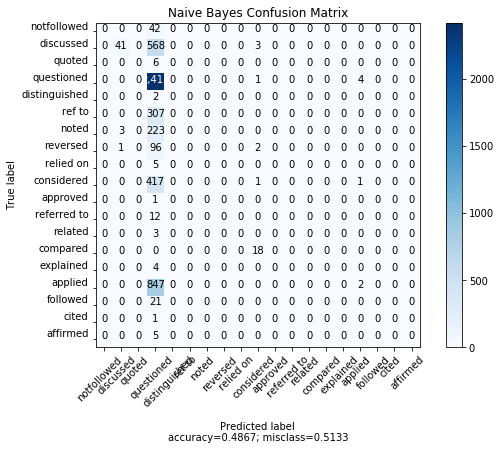

In [49]:
nb_conf_matrix=confusion_matrix(test_labels,legal_predict)
plot_confusion_matrix(cm           = nb_conf_matrix, 
                      normalize    = False,
                      target_names = set(test_labels),
                      title        = "Naive Bayes Confusion Matrix")

# ROCCHIO 

In [53]:
#Get an Instance of the Rocchhio Classifier
legal_rocchio=NearestCentroid()
#Train Rocchhio Classifier on training data and labels
legal_rocchio.fit(X=train_data,y=train_labels)
#Make Predictions on Test Data
legal_roc_predict=legal_rocchio.predict(test_data)

<h3> Model Evaluation</h3>

In [54]:
print('Micro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_roc_predict, average='micro'))
print('Macro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_roc_predict, average='macro'))
print('Accuracy : ',accuracy_score(y_true=test_labels, y_pred = legal_roc_predict))

Micro F1 Score :  0.2717735550277118


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Macro F1 Score :  0.12504740532477887
Accuracy :  0.2717735550277118


<h3>Confusion Matrix</h3>

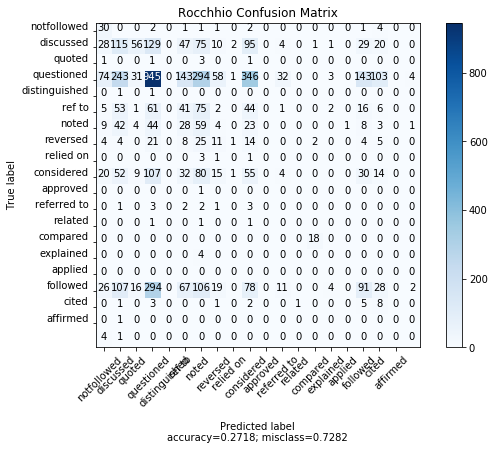

In [59]:
roc_conf_matrix=confusion_matrix(test_labels,legal_roc_predict)
plot_confusion_matrix(cm           = roc_conf_matrix, 
                      normalize    = False,
                      target_names = set(test_labels),
                      title        = "Rocchhio Confusion Matrix")

# kNN k =3

In [17]:
#Get an Instance of the kNN Classifier
legal_knn3=KNeighborsClassifier(n_neighbors=3)
#Train kNN Classifier on training data and labels
legal_knn3.fit(X=train_data,y=train_labels)
#Make Predictions on Test Data
legal_knn3_predict=legal_knn3.predict(test_data)

<h3> Model Evaluation</h3>

In [18]:
print('Micro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn3_predict, average='micro'))
print('Macro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn3_predict, average='macro'))
print('Accuracy : ',accuracy_score(y_true=test_labels, y_pred = legal_knn3_predict))

Micro F1 Score :  0.46140142517814725


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 Score :  0.061884912642111
Accuracy :  0.46140142517814725


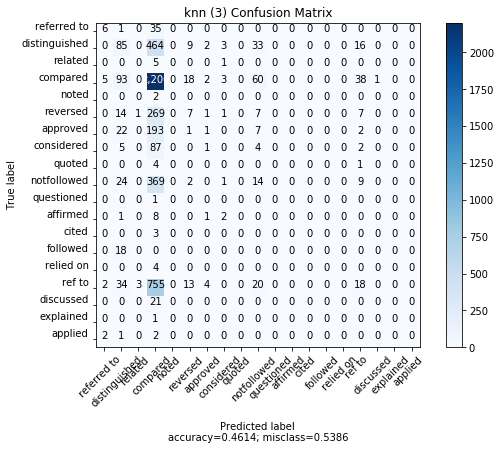

In [20]:
knn3_conf_matrix=confusion_matrix(test_labels,legal_knn3_predict)
plot_confusion_matrix(cm           = knn3_conf_matrix, 
                      normalize    = False,
                      target_names = set(test_labels),
                      title        = "knn (3) Confusion Matrix")

# kNN k =5

In [21]:
#Get an Instance of the kNN Classifier
legal_knn5=KNeighborsClassifier(n_neighbors=5)
#Train kNN Classifier on training data and labels
legal_knn5.fit(X=train_data,y=train_labels)
#Make Predictions on Test Data
legal_knn5_predict=legal_knn5.predict(test_data)

<h3> Model Evaluation</h3>

In [22]:
print('Micro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn5_predict, average='micro'))
print('Macro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn5_predict, average='macro'))
print('Accuracy : ',accuracy_score(y_true=test_labels, y_pred = legal_knn5_predict))

Micro F1 Score :  0.37826603325415675


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 Score :  0.09956861922492265
Accuracy :  0.37826603325415675


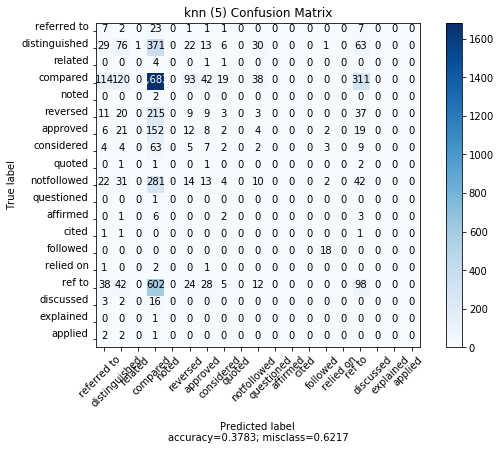

In [23]:
knn5_conf_matrix=confusion_matrix(test_labels,legal_knn5_predict)
plot_confusion_matrix(cm           = knn5_conf_matrix, 
                      normalize    = False,
                      target_names = set(test_labels),
                      title        = "knn (5) Confusion Matrix")

# kNN k =7

In [24]:
#Get an Instance of the kNN Classifier
legal_knn7=KNeighborsClassifier(n_neighbors=7)
#Train kNN Classifier on training data and labels
legal_knn7.fit(X=train_data,y=train_labels)
#Make Predictions on Test Data
legal_knn7_predict=legal_knn7.predict(test_data)

<h3> Model Evaluation</h3>

In [25]:
print('Micro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn7_predict, average='micro'))
print('Macro F1 Score : ',f1_score(y_true=test_labels, y_pred = legal_knn7_predict, average='macro'))
print('Accuracy : ',accuracy_score(y_true=test_labels, y_pred = legal_knn7_predict))

Micro F1 Score :  0.413895486935867


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 Score :  0.09725438224822257
Accuracy :  0.413895486935867


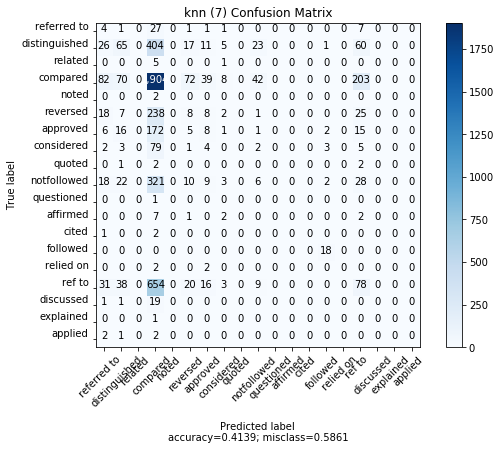

In [26]:
knn7_conf_matrix=confusion_matrix(test_labels,legal_knn7_predict)
plot_confusion_matrix(cm           = knn7_conf_matrix, 
                      normalize    = False,
                      target_names = set(test_labels),
                      title        = "knn (7) Confusion Matrix")